In [1]:
TRAIN_PATH = "CovidDataset/Train"
VAL_PATH = "CovidDataset/Val"
TEST_PATH = "CovidDataset/test"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,EarlyStopping, CSVLogger

In [3]:
from keras.metrics import *

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
]

In [4]:
# Train from scratch
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=45,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_dataset = image.ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 8764 images belonging to 2 classes.


In [6]:
validation_generator = test_dataset.flow_from_directory(
    VAL_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 2150 images belonging to 2 classes.


In [7]:
test_generator = test_dataset.flow_from_directory(
    TEST_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 800 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'Covid': 0, 'Negative': 1}

In [9]:
import os
from keras.callbacks import ModelCheckpoint,EarlyStopping, CSVLogger
checkpoint_path = "mobilenetV2checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', verbose=1,save_weights_only=True,save_best_only=True, mode='auto')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
log_csv = CSVLogger('mobilenetv2.csv', separator=',', append=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5)

callbacks_list = [checkpoint,log_csv]


In [10]:
from tensorflow.keras.optimizers import Adam
opt= Adam()

In [11]:
def create_model():

    base_model = tf.keras.applications.MobileNetV2(
        include_top=False, 
        pooling = 'avg', 
        weights='imagenet',
        input_shape=(224, 224, 3), 
        classes=1000)
    
    for layer in base_model.layers:
      layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(256))
#     model.add(Dropout(0.1))
    
    model.add(Dense(128))
    model.add(Dropout(0.2))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(32))
#     model.add(Dropout(0.1))
    
    model.add(Dense(1, activation='sigmoid'))
    
    #model.layers[0].trainable = False
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    return model

In [12]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
activation (Activation)      (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [13]:

hist = model.fit_generator(
          train_generator,
          steps_per_epoch = len(train_generator),
          validation_data=validation_generator,
          epochs=100,
          validation_steps=len(validation_generator),
          callbacks=callbacks_list
                 )

C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
274/274 [==============================] - 109s 371ms/step - loss: 0.3416 - tp: 4515.0000 - fp: 719.0000 - tn: 2962.0000 - fn: 568.0000 - accuracy: 0.8531 - precision: 0.8626 - recall: 0.8883 - val_loss: 0.1817 - val_tp: 1721.0000 - val_fp: 104.0000 - val_tn: 310.0000 - val_fn: 15.0000 - val_accuracy: 0.9447 - val_precision: 0.9430 - val_recall: 0.9914

Epoch 00001: loss improved from inf to 0.34163, saving model to mobilenetV2checkpoints\cp-0001.ckpt
Epoch 2/100
274/274 [==============================] - 99s 361ms/step - loss: 0.2750 - tp: 4657.0000 - fp: 586.0000 - tn: 3095.0000 - fn: 426.0000 - accuracy: 0.8845 - precision: 0.8882 - recall: 0.9162 - val_loss: 0.1884 - val_tp: 1669.0000 - val_fp: 95.0000 - val_tn: 319.0000 - val_fn: 67.0000 - val_accuracy: 0.9247 - val_precision: 0.9461 - val_recall: 0.9614

Epoch 00002: loss improved from 0.34163 to 0.27505, saving model to mobilenetV2checkpoints\cp-0002.ckpt
Epoch 3/100
274/274 [==============================] - 97s 355


Epoch 00018: loss did not improve from 0.17812
Epoch 19/100
274/274 [==============================] - 101s 370ms/step - loss: 0.1802 - tp: 4805.0000 - fp: 318.0000 - tn: 3363.0000 - fn: 278.0000 - accuracy: 0.9320 - precision: 0.9379 - recall: 0.9453 - val_loss: 0.1637 - val_tp: 1696.0000 - val_fp: 90.0000 - val_tn: 324.0000 - val_fn: 40.0000 - val_accuracy: 0.9395 - val_precision: 0.9496 - val_recall: 0.9770

Epoch 00019: loss did not improve from 0.17812
Epoch 20/100
274/274 [==============================] - 100s 366ms/step - loss: 0.1700 - tp: 4815.0000 - fp: 315.0000 - tn: 3366.0000 - fn: 268.0000 - accuracy: 0.9335 - precision: 0.9386 - recall: 0.9473 - val_loss: 0.2635 - val_tp: 1542.0000 - val_fp: 48.0000 - val_tn: 366.0000 - val_fn: 194.0000 - val_accuracy: 0.8874 - val_precision: 0.9698 - val_recall: 0.8882

Epoch 00020: loss improved from 0.17812 to 0.17002, saving model to mobilenetV2checkpoints\cp-0020.ckpt
Epoch 21/100
274/274 [==============================] - 98s 357m


Epoch 00037: loss did not improve from 0.15375
Epoch 38/100
274/274 [==============================] - 97s 354ms/step - loss: 0.1555 - tp: 4837.0000 - fp: 274.0000 - tn: 3407.0000 - fn: 246.0000 - accuracy: 0.9407 - precision: 0.9464 - recall: 0.9516 - val_loss: 0.2843 - val_tp: 1517.0000 - val_fp: 53.0000 - val_tn: 361.0000 - val_fn: 219.0000 - val_accuracy: 0.8735 - val_precision: 0.9662 - val_recall: 0.8738

Epoch 00038: loss did not improve from 0.15375
Epoch 39/100
274/274 [==============================] - 100s 367ms/step - loss: 0.1515 - tp: 4844.0000 - fp: 259.0000 - tn: 3422.0000 - fn: 239.0000 - accuracy: 0.9432 - precision: 0.9492 - recall: 0.9530 - val_loss: 0.2972 - val_tp: 1499.0000 - val_fp: 41.0000 - val_tn: 373.0000 - val_fn: 237.0000 - val_accuracy: 0.8707 - val_precision: 0.9734 - val_recall: 0.8635

Epoch 00039: loss improved from 0.15375 to 0.15146, saving model to mobilenetV2checkpoints\cp-0039.ckpt
Epoch 40/100
274/274 [==============================] - 99s 360m


Epoch 00056: loss did not improve from 0.13387
Epoch 57/100
274/274 [==============================] - 98s 357ms/step - loss: 0.1340 - tp: 4859.0000 - fp: 231.0000 - tn: 3450.0000 - fn: 224.0000 - accuracy: 0.9481 - precision: 0.9546 - recall: 0.9559 - val_loss: 0.2506 - val_tp: 1614.0000 - val_fp: 71.0000 - val_tn: 343.0000 - val_fn: 122.0000 - val_accuracy: 0.9102 - val_precision: 0.9579 - val_recall: 0.9297

Epoch 00057: loss did not improve from 0.13387
Epoch 58/100
274/274 [==============================] - 97s 356ms/step - loss: 0.1388 - tp: 4865.0000 - fp: 243.0000 - tn: 3438.0000 - fn: 218.0000 - accuracy: 0.9474 - precision: 0.9524 - recall: 0.9571 - val_loss: 0.2695 - val_tp: 1573.0000 - val_fp: 57.0000 - val_tn: 357.0000 - val_fn: 163.0000 - val_accuracy: 0.8977 - val_precision: 0.9650 - val_recall: 0.9061

Epoch 00058: loss did not improve from 0.13387
Epoch 59/100
274/274 [==============================] - 97s 355ms/step - loss: 0.1411 - tp: 4840.0000 - fp: 243.0000 - tn:


Epoch 00075: loss did not improve from 0.12181
Epoch 76/100
274/274 [==============================] - 95s 346ms/step - loss: 0.1236 - tp: 4874.0000 - fp: 220.0000 - tn: 3461.0000 - fn: 209.0000 - accuracy: 0.9510 - precision: 0.9568 - recall: 0.9589 - val_loss: 0.3174 - val_tp: 1542.0000 - val_fp: 62.0000 - val_tn: 352.0000 - val_fn: 194.0000 - val_accuracy: 0.8809 - val_precision: 0.9613 - val_recall: 0.8882

Epoch 00076: loss did not improve from 0.12181
Epoch 77/100
274/274 [==============================] - 95s 346ms/step - loss: 0.1275 - tp: 4869.0000 - fp: 230.0000 - tn: 3451.0000 - fn: 214.0000 - accuracy: 0.9493 - precision: 0.9549 - recall: 0.9579 - val_loss: 0.2772 - val_tp: 1616.0000 - val_fp: 101.0000 - val_tn: 313.0000 - val_fn: 120.0000 - val_accuracy: 0.8972 - val_precision: 0.9412 - val_recall: 0.9309

Epoch 00077: loss did not improve from 0.12181
Epoch 78/100
274/274 [==============================] - 95s 345ms/step - loss: 0.1236 - tp: 4882.0000 - fp: 198.0000 - tn

In [14]:
model.evaluate_generator(train_generator)

C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.08187834918498993,
 4970.0,
 134.0,
 3547.0,
 113.0,
 0.9718165397644043,
 0.9737460613250732,
 0.9777690172195435]

In [15]:
model.evaluate_generator(validation_generator)

[0.23316438496112823,
 1615.0,
 53.0,
 361.0,
 121.0,
 0.919069766998291,
 0.9682254195213318,
 0.9302995204925537]

In [16]:
os.listdir(checkpoint_dir)

['checkpoint',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0001.ckpt.index',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0002.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0003.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0006.ckpt.index',
 'cp-0007.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0008.ckpt.data-00000-of-00001',
 'cp-0008.ckpt.index',
 'cp-0009.ckpt.data-00000-of-00001',
 'cp-0009.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0011.ckpt.data-00000-of-00001',
 'cp-0011.ckpt.index',
 'cp-0012.ckpt.data-00000-of-00001',
 'cp-0012.ckpt.index',
 'cp-0013.ckpt.data-00000-of-00001',
 'cp-0013.ckpt.index',
 'cp-0014.ckpt.data-00000-of-00001',
 'cp-0014.ckpt.index',
 'cp-0015.ckpt.data-00000-of-00001',
 'cp-0015.ckpt.index',
 'cp-0016.ckpt.data-00000-of-00001',
 'cp-0016.ckpt.index',
 'cp-0017.ckpt.data-00000

In [17]:
import tensorflow
latest = tensorflow.train.latest_checkpoint(checkpoint_dir)
latest

'mobilenetV2checkpoints\\cp-0098.ckpt'

In [18]:
model.evaluate_generator(validation_generator)

[0.23316438496112823,
 1615.0,
 53.0,
 361.0,
 121.0,
 0.919069766998291,
 0.9682254195213318,
 0.9302995204925537]

In [19]:
# model.evaluate_generator(validation_generator)

In [20]:
model.evaluate_generator(test_generator)

[0.32694417238235474,
 345.0,
 51.0,
 349.0,
 55.0,
 0.8675000071525574,
 0.8712121248245239,
 0.862500011920929]

In [21]:
# Create a basic model instance
model = create_model()

# Evaluate the model
results = model.evaluate_generator(validation_generator, 1)
print("The model has a {}% accuracy, with a loss of {}.".format(results[5]*100, results[0])) 


The model has a 85.9375% accuracy, with a loss of 0.622771143913269.


In [22]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

results = model.evaluate_generator(validation_generator, 1)
print("The model has a {}% accuracy, with a loss of {}.".format(results[5]*100, results[0])) 


The model has a 86.11111044883728% accuracy, with a loss of 0.39513063430786133.


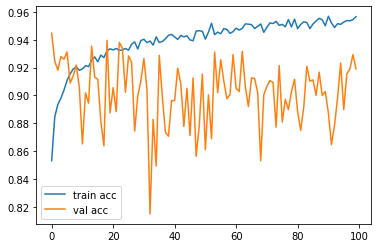

<Figure size 432x288 with 0 Axes>

In [23]:
# accuracies
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

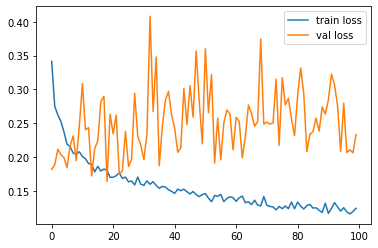

<Figure size 432x288 with 0 Axes>

In [24]:
# loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [25]:
y_actual = []
y_test = []

In [26]:
import os
from keras.preprocessing import image
import numpy as np
for i in os.listdir("CovidData/Val/negative/"):
   img = image.load_img("CovidData/Val/negative/"+i, target_size= (224, 224));
   img = image.img_to_array(img)
   img = np.expand_dims(img, axis = 0)
   p = model.predict(img)
   classes_x=np.argmax(p,axis=0)
   y_test.append(p[0,0])
   y_actual.append(1)


In [27]:
for i in os.listdir("CovidData/val/covid/"):
   img = image.load_img("CovidData/Val/covid/"+i, target_size= (224, 224));
   img = image.img_to_array(img)
   img = np.expand_dims(img, axis = 0)
   p = model.predict(img)
   classes_x=np.argmax(p,axis=0)
   y_test.append(p[0,0])
   y_actual.append(0)


In [28]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

In [29]:
print(y_actual)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
print(y_test)

[7.8550019e-13 4.2577382e-15 4.8359933e-14 2.3195894e-12 4.6629471e-12
 7.5269203e-15 2.9188755e-13 3.7790587e-12 6.8136261e-11 3.5254948e-12
 1.0570082e-12 1.1412383e-16 6.2741723e-14 3.4782843e-13 3.2756217e-16
 1.0218314e-12 5.9675247e-13 6.6823786e-17 2.8175196e-10 8.7045562e-12
 1.6667853e-11 3.5529696e-12 2.0658359e-14 4.8053656e-14 2.0381261e-18
 1.1034510e-14 7.4791150e-17 5.7089404e-18 1.2332153e-16 1.2525199e-10
 2.9069226e-11 7.5699885e-10 4.7172648e-12 3.8887071e-10 1.0501908e-10
 1.1132532e-11 1.5914862e-15 1.6880885e-07 3.5364100e-13 7.2570519e-11
 6.5735919e-15 2.1226368e-11 1.4149566e-12 3.1121075e-14 8.7450197e-10
 6.0315287e-08 1.6512448e-08 6.7314104e-10 6.3819387e-11 2.9081978e-11
 8.3215130e-13 3.1603251e-11 1.2847709e-10 6.1168314e-12 2.8615410e-09
 2.5557815e-08 9.2564223e-10 1.0996439e-14 8.2515754e-09 2.4122099e-14]


In [31]:
import seaborn as sns

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_actual, np.round(abs(y_test))))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        30
           1       0.00      0.00      0.00        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
from sklearn.metrics import roc_auc_score,auc
roc_auc = roc_auc_score(y_actual, np.round(abs(y_test)))

roc_auc

0.5

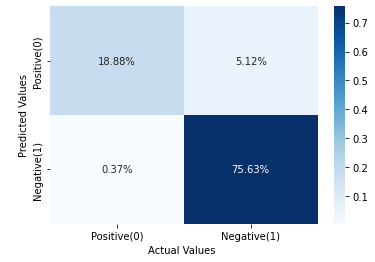

In [34]:
cm=[[406, 110],
     [ 8, 1626]]

import seaborn as sns

ax = sns.heatmap(cm/np.sum(cm), cmap = "Blues", fmt='.2%', annot=True)

ax.set_ylabel('\nPredicted Values')
ax.set_xlabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['Positive(0)','Negative(1)'])
ax.xaxis.set_ticklabels(['Positive(0)','Negative(1)'])

## Display the visualization of the Confusion Matrix.
plt.show()

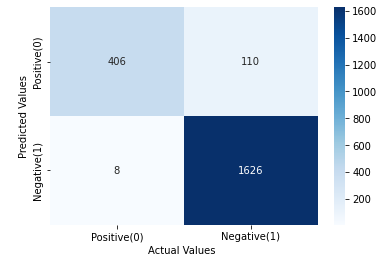

In [35]:
from numpy import *
cm=[[406, 110],
     [ 8, 1626]]

import seaborn as sns

ax = sns.heatmap(cm, cmap = "Blues", annot=True, fmt=".0f")

ax.set_ylabel('\nPredicted Values')
ax.set_xlabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['Positive(0)','Negative(1)'])
ax.xaxis.set_ticklabels(['Positive(0)','Negative(1)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_actual, np.round(abs(y_test))))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        30
           1       0.00      0.00      0.00        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\TF-Gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
